In [1]:
# tools
import pandas as pd
import matplotlib.pyplot as plt

# forecast
from neuralforecast.core import NeuralForecast

# models
from neuralforecast.models import TimesNet

import logging
logging.getLogger("pytorch_lightning").setLevel(logging.WARNING)

import warnings
warnings.filterwarnings("ignore")

# data

## basic data

In [6]:
df = pd.read_csv("https://datasets-nixtla.s3.amazonaws.com/EPF_FR_BE.csv")
df["ds"] = pd.to_datetime(df["ds"])

print(df.head(), "\n")
print(df.tail(), "\n")
print(df.shape, "\n")
print(df["unique_id"].value_counts())

  unique_id                  ds      y  gen_forecast  system_load  week_day
0        FR 2015-01-01 00:00:00  53.48       76905.0      74812.0         3
1        FR 2015-01-01 01:00:00  51.93       75492.0      71469.0         3
2        FR 2015-01-01 02:00:00  48.76       74394.0      69642.0         3
3        FR 2015-01-01 03:00:00  42.27       72639.0      66704.0         3
4        FR 2015-01-01 04:00:00  38.41       69347.0      65051.0         3 

      unique_id                  ds      y  gen_forecast  system_load   
32155        BE 2016-10-31 19:00:00  65.83       55041.0      59537.0  \
32156        BE 2016-10-31 20:00:00  56.11       53535.0      53823.0   
32157        BE 2016-10-31 21:00:00  40.26       49893.0      50622.0   
32158        BE 2016-10-31 22:00:00  38.62       49037.0      49194.0   
32159        BE 2016-10-31 23:00:00  38.65       49094.0      53441.0   

       week_day  
32155         0  
32156         0  
32157         0  
32158         0  
32159        

## future exogenous

In [8]:
futr_df= pd.read_csv("https://datasets-nixtla.s3.amazonaws.com/EPF_FR_BE_futr.csv")
futr_df["ds"] = pd.to_datetime(futr_df["ds"])

print(futr_df.head(), "\n")
print(futr_df.tail(), "\n")
print(futr_df.shape, "\n")
print(futr_df["unique_id"].value_counts())

  unique_id                  ds  gen_forecast  week_day
0        FR 2016-11-01 00:00:00       49118.0         1
1        FR 2016-11-01 01:00:00       47890.0         1
2        FR 2016-11-01 02:00:00       47158.0         1
3        FR 2016-11-01 03:00:00       45991.0         1
4        FR 2016-11-01 04:00:00       45378.0         1 

   unique_id                  ds  gen_forecast  week_day
43        BE 2016-11-01 19:00:00       51960.0         1
44        BE 2016-11-01 20:00:00       51040.0         1
45        BE 2016-11-01 21:00:00       49577.0         1
46        BE 2016-11-01 22:00:00       49011.0         1
47        BE 2016-11-01 23:00:00       49661.0         1 

(48, 4) 

unique_id
FR    24
BE    24
Name: count, dtype: int64


# time series scaling: 训练前

## model training

In [9]:
horizon = 24
nf = NeuralForecast(
    models = [
        TimesNet(
            h = horizon,
            input_size = 5 * horizon,
            max_steps = 100,
            top_k = 3,  # number of periods for FFT
            num_kernels = 3,  # number of kernels for Inception module
            batch_size = 2,
            windows_batch_size = 32,
            learning_rate = 0.001,
            futr_exog_list = [
                "gen_forecast", 
                # "system_load", 
                "week_day"
            ],
            scaler_type = None,
        )
    ],
    freq = "h",
    local_scaler_type = "standard"
)
nf.fit(df = df)

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

## model predicting

In [18]:
Y_hat_df = nf.predict(futr_df = futr_df)
print(Y_hat_df.head(), "\n")
print(Y_hat_df.shape, "\n")
print(Y_hat_df.index.value_counts())

Predicting: 0it [00:00, ?it/s]

                           ds   TimesNet
unique_id                               
BE        2016-11-01 00:00:00  43.373558
BE        2016-11-01 01:00:00  38.010551
BE        2016-11-01 02:00:00  38.114948
BE        2016-11-01 03:00:00  34.156353
BE        2016-11-01 04:00:00  38.428112 

(48, 2) 

unique_id
BE    24
FR    24
Name: count, dtype: int64


## result

In [19]:
Y_hat_df = Y_hat_df.reset_index(drop=False)

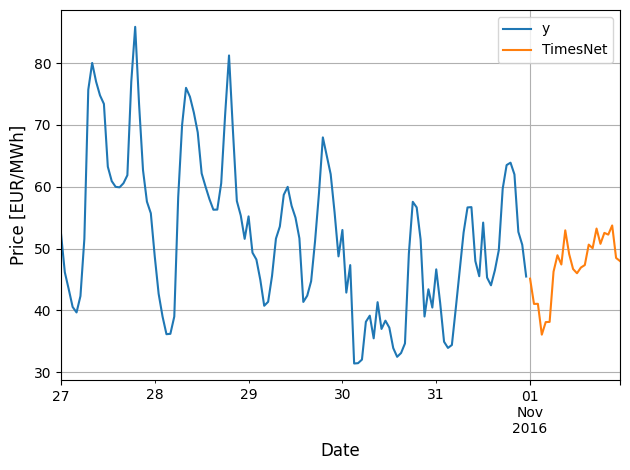

In [22]:
plot_df = df[df['unique_id']=='FR'].tail(24*5).reset_index(drop=True)
Y_hat_df_FR = Y_hat_df[Y_hat_df['unique_id']=='FR']
plot_df = pd.concat([plot_df, Y_hat_df_FR ]).set_index('ds')

plot_df[['y', 'TimesNet']].plot(linewidth=1.5)
plt.axvline(pd.to_datetime('2016-11-01'), color='red')
plt.ylabel('Price [EUR/MWh]', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.tight_layout()
plt.grid()

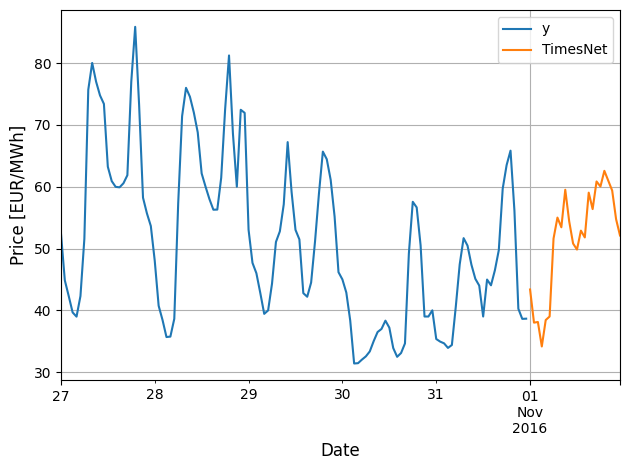

In [23]:
plot_df = df[df['unique_id']=='BE'].tail(24*5).reset_index(drop=True)
Y_hat_df_BE = Y_hat_df[Y_hat_df['unique_id']=='BE']
plot_df = pd.concat([plot_df, Y_hat_df_BE ]).set_index('ds')

plot_df[['y', 'TimesNet']].plot(linewidth=1.5)
plt.axvline(pd.to_datetime('2016-11-01'), color='red')
plt.ylabel('Price [EUR/MWh]', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.tight_layout()
plt.grid()

# temporal window normalization: 训练中

## model training

In [24]:
horizon = 24
nf = NeuralForecast(
    models = [
        TimesNet(
            h = horizon,
            input_size = 5 * horizon,
            max_steps = 100,
            top_k = 3,  # number of periods for FFT
            num_kernels = 3,  # number of kernels for Inception module
            batch_size = 2,
            windows_batch_size = 32,
            learning_rate = 0.001,
            futr_exog_list = [
                "gen_forecast", 
                # "system_load", 
                "week_day"
            ],
            scaler_type = "robust",
        )
    ],
    freq = "h",
    local_scaler_type = None,  # 避免在训练前缩放数据
)
nf.fit(df = df)

Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

## model predicting

In [26]:
Y_hat_df = nf.predict(futr_df = futr_df)
print(Y_hat_df.head(), "\n")
print(Y_hat_df.shape, "\n")
print(Y_hat_df.index.value_counts())

Predicting: 0it [00:00, ?it/s]

                           ds   TimesNet
unique_id                               
BE        2016-11-01 00:00:00  40.693977
BE        2016-11-01 01:00:00  36.531837
BE        2016-11-01 02:00:00  36.343292
BE        2016-11-01 03:00:00  38.032242
BE        2016-11-01 04:00:00  37.369678 

(48, 2) 

unique_id
BE    24
FR    24
Name: count, dtype: int64


## result

In [27]:
Y_hat_df = Y_hat_df.reset_index(drop=False)

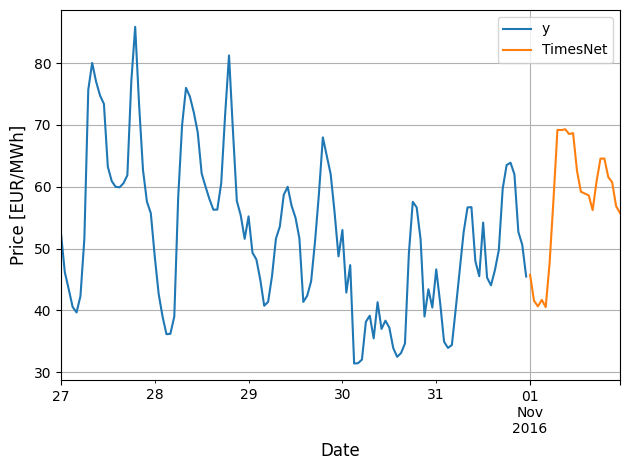

In [28]:
plot_df = df[df['unique_id']=='FR'].tail(24*5).reset_index(drop=True)
Y_hat_df_FR = Y_hat_df[Y_hat_df['unique_id']=='FR']
plot_df = pd.concat([plot_df, Y_hat_df_FR ]).set_index('ds')

plot_df[['y', 'TimesNet']].plot(linewidth=1.5)
plt.axvline(pd.to_datetime('2016-11-01'), color='red')
plt.ylabel('Price [EUR/MWh]', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.tight_layout()
plt.grid()

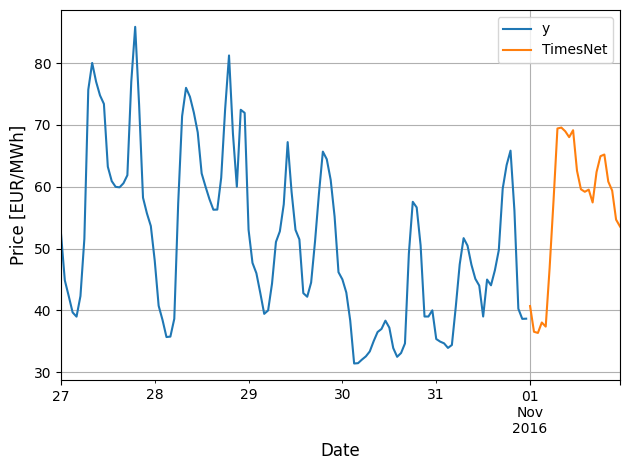

In [29]:
plot_df = df[df['unique_id']=='BE'].tail(24*5).reset_index(drop=True)
Y_hat_df_FR = Y_hat_df[Y_hat_df['unique_id']=='BE']
plot_df = pd.concat([plot_df, Y_hat_df_FR ]).set_index('ds')

plot_df[['y', 'TimesNet']].plot(linewidth=1.5)
plt.axvline(pd.to_datetime('2016-11-01'), color='red')
plt.ylabel('Price [EUR/MWh]', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.tight_layout()
plt.grid()